Task 4b:
- Implement a similar image search algorithm using this index structure storing the even numbered Caltec101 images and a visual model of your choic (the combined visual model must have at least 256 dimensions): for a given query image and integer t,
    - visulizes the t most similar images,
    - outputs the numbers of unique and overall number of images considered during the process.

In [1]:
import numpy as np
import random
import itertools
import math

import pandas as pd
import pickle

import json
import torch
from torchvision.datasets import Caltech101
from torchvision.models  import resnet50, ResNet50_Weights
from torchvision import models, transforms
from scipy.special import softmax

import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, minkowski, correlation
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import collections

In [2]:
path = '/content/drive/MyDrive/CSE515_Phase3'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
caltech_dataset = Caltech101(root = f'{path}/data', download = False)

In [6]:
json_file = f"{path}/feature_descriptors.json"
with open(json_file, 'r') as file:
  feature_descriptors = json.load(file)

data = pd.DataFrame(feature_descriptors).T.reset_index(names="id")
input_vectors = np.array(data["layer_3"].tolist())

In [14]:
# Get the Resnet50 output for an image by hooks in intermediate layers: layer3, avgpool, fc
def computeResNet50Vectors(imageId, dataset):
    image, label = dataset[imageId]
    if (image.mode == 'L') :
      image = image.convert("RGB")
    with torch.no_grad():
      resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)          # Loading the ResNet50 model
      hook_output_avg_pool = []                          # list to store the ResNet50 avg pool layer output
      hook_output_layer3 = []                            # list to store the ResNet50 layer-3 layer output
      hook_output_fc = []                                # list to store the ResNet50 Full Connected layer output


      # Hook defined to capture the feature vectors from the avg_pool layer
      def hook_fn(module, input, output):
          hook_output_avg_pool.append(output)

      # Hook defined to capture the feature vectors from the Layer3
      def hook_fn_layer3(module, input, output):
          hook_output_layer3.append(output)

      # Hook defined to capture the feature vectors from the Fully Connected layer
      def hook_fn_fc(module, input, output):
          hook_output_fc.append(output)


      # Registering the defined hook as the forward hook on the avg pool layer on the ResNet 50 model
      avgpool_layer = resnet.avgpool
      avgpool_layer.register_forward_hook(hook_fn)

      # Registering the defined hook as the forward hook on the layer-3 on the ResNet 50 model
      layer3 = resnet.layer3
      layer3.register_forward_hook(hook_fn_layer3)

      # Registering the defined hook as the forward hook on the fully connected layer on the ResNet 50 model
      fc_layer = resnet.fc
      fc_layer.register_forward_hook(hook_fn_fc)

      # Performing tranform operations on the image to resize it and retrieve the tensors from each layer
      transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
      image = transform(image).unsqueeze(0)
      resnet(image)                # Passing the image to the ResNet Model


      #Storing the output of the hooks in the predefined lists
      avgpool_vector = hook_output_avg_pool[0][0]
      layer3_vector = hook_output_layer3[0][0]
      fc_vector = hook_output_fc[0][0]


      avgpool_vector = avgpool_vector.squeeze().detach().numpy().reshape(1024, 2)           # Converting the vectors from tensor to numpy to perform mathematical operations
      reduced_avg_pool_dimensionality_vector = np.mean(avgpool_vector, axis = 1)            # Dimensional Reduction is perfromed by averaging up the consecutive numbers and reducing the resultant array to 1D

      layer3_vector = layer3_vector.detach().numpy()                                        # Converting the vectors from tensor to numpy to perform mathematical operations
      reduced_layer3_dimensionality_vector = np.mean(layer3_vector, axis = (1, 2))          # Dimensional Reduction is perfromed by averaging up the 14, 14 slice and reducing the resultant array to 1D

      fc_vector = fc_vector.detach().numpy()                                                            # Converting the vectors from tensor to numpy to perform mathematical operations
      resnet = softmax(fc_vector)
    return (reduced_avg_pool_dimensionality_vector, reduced_layer3_dimensionality_vector, fc_vector, resnet)  # returning the feature descriptors of all 3 layers in a tuple

In [8]:
class LSH:
  def __init__(self, L, h, input_vectors):
    self.L = L
    self.h = h
    self.W = 0.0
    self.vectors = input_vectors
    self.lsh_hyperplanes = {}
    self.lsh_hyperplane_ranges = {}
    self.hash_tables = [{} for _ in range(self.L)]

  def create_index(self):
    self.init_random_hyperplanes()
    self.W = min(self.lsh_hyperplane_ranges.values()) / float(50)

    for vector_id, vector in enumerate(self.vectors):
      for layer_id in range(self.L):
        bucket_key = self.get_bucket_key(vector, layer_id)
        if bucket_key not in self.hash_tables[layer_id]:
          self.hash_tables[layer_id][bucket_key] = set()
        self.hash_tables[layer_id][bucket_key].add(vector_id)

  def init_random_hyperplanes(self):
    # Define the origin vector with zeros, size should match the number of features (1024)
    origin_vector = np.zeros(self.vectors.shape[1])

    # Iterate through each layer and hash
    for layer_id in range(self.L):
      for hash_id in range(self.h):
        random_hyperplane_vector = []

        # Iterate through each feature
        for col in range(self.vectors.shape[1]):
          # Get min and max of the current feature across all data points
          min_val = self.vectors[:, col].min()
          max_val = self.vectors[:, col].max()

          # Get a random value between min and max
          random_val = random.uniform(min_val, max_val)
          random_hyperplane_vector.append(random_val)

        random_hyperplane_vector = np.array(random_hyperplane_vector)

        # Store the hyperplane vector and its distance from the origin
        hyperplane_key = (layer_id, hash_id)
        self.lsh_hyperplanes[hyperplane_key] = random_hyperplane_vector
        self.lsh_hyperplane_ranges[hyperplane_key] = euclidean(origin_vector, random_hyperplane_vector)

  def get_bucket_key(self, vector, layer_id):
    bucket_key = []
    for hash_id in range(self.h):
      hyperplane = self.lsh_hyperplanes[(layer_id, hash_id)]
      projected_value = self.project_on_hyperplane(vector, hyperplane)
      bucket_key.append(self.assign_vector(projected_value))
    return tuple(bucket_key)

  def project_on_hyperplane(self, input_vector, lsh_vector):
    dp = np.dot(input_vector, lsh_vector)
    if dp == 0.0:
      return 0
    projection = dp/np.dot(lsh_vector, lsh_vector)*lsh_vector
    magnitude = np.linalg.norm(projection)
    return magnitude

  def assign_vector(self, value):
    if value < 0:
      return math.floor(value/self.W)
    else:
      return math.ceil(value/self.W)

  def query(self, query_vector):
    results = []
    for layer_id in range(self.L):
      bucket_key = self.get_bucket_key(query_vector, layer_id)
      results.extend(list(self.hash_tables[layer_id].get(bucket_key, set())))
    return results

  def get_adjacent_buckets(self, bucket_key, layer_id):
    adjacent_keys = []

    mini = min(min(self.hash_tables[layer_id].keys()))
    maxi = max(max(self.hash_tables[layer_id].keys()))

    for delta in range(1, maxi - mini + 1):
      for i in range(len(bucket_key)):
        modified_key = list(bucket_key)
        modified_key[i] -= delta
      adjacent_keys.append(tuple(modified_key))
      for i in range(len(bucket_key)):
        modified_key = list(bucket_key)
        modified_key[i] += delta
      adjacent_keys.append(tuple(modified_key))

    return adjacent_keys

  def expanded_lsh_query(self, query_vector, t):
    results = self.query(query_vector)

    # Check if we need to expand the search
    if len(set(results)) >= t:
      return results

    # Expand to adjacent buckets
    for layer_id in range(self.L):
      bucket_key = self.get_bucket_key(query_vector, layer_id)
      for adj_key in self.get_adjacent_buckets(bucket_key, layer_id):
        if adj_key in self.hash_tables[layer_id].keys() and adj_key != bucket_key:
          results.extend(list(self.hash_tables[layer_id].get(adj_key, set())))
          if len(set(results)) >= t:
              return results

    return results

  def print_bucket_sizes(self):
    for layer_id, layer in enumerate(self.hash_tables):
      print(f"Layer {layer_id}:")
      for bucket_key, bucket in layer.items():
        print(f"  Bucket {bucket_key}: {len(bucket)} images")

In [9]:
def similar_image_search_lsh(lsh, query_image_index, t):
  resnet_outputs = computeResNet50Vectors(query_image_index, caltech_dataset)
  query_vector = resnet_outputs[1]

  candidates_union = lsh.expanded_lsh_query(query_vector, t)

  candidates_id = list(set(candidates_union))

  candidate_vectors = [lsh.vectors[i] for i in candidates_id]

  if len(candidates_id) < t:
    distances = euclidean_distances([query_vector], input_vectors)[0]
    sorted_indices = np.argsort(distances)

    similar_images = [i * 2 for i in sorted_indices[:t]]

    return similar_images, len(input_vectors), len(input_vectors)

  # Calculate Euclidean distances
  distances = euclidean_distances([query_vector], candidate_vectors)[0]

  # Sort candidates by distance
  sorted_indices = np.argsort(distances)

  # Visualize the t most similar images
  similar_images = [list(candidates_id)[i]*2 for i in sorted_indices[:t]]

  return similar_images, len(candidates_id), len(candidates_union)

In [10]:
def display_images(image_indices, dataset, w, h):
    fig, axs = plt.subplots(1, len(image_indices), figsize=(30, 10))
    for i, index in enumerate(image_indices):
        image_array = np.array(dataset[int(index)][0])  # Convert JpegImageFile to NumPy array
        image = Image.fromarray(image_array)
        axs[i].imshow(image.resize((w, h)))
        axs[i].axis('off')
        axs[i].set_title(f"Image {int(index)}")
    plt.show()

In [11]:
def load_lsh_index_from_file(filename):
    with open(filename, 'rb') as file:
        lsh = pickle.load(file)
    return lsh

Enter the query image id: 8675
Enter the number of most likely images to retrive, t: 10
Original Image


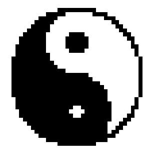


Number of Unique Images Considered: 861
Total Number of Images: 6391


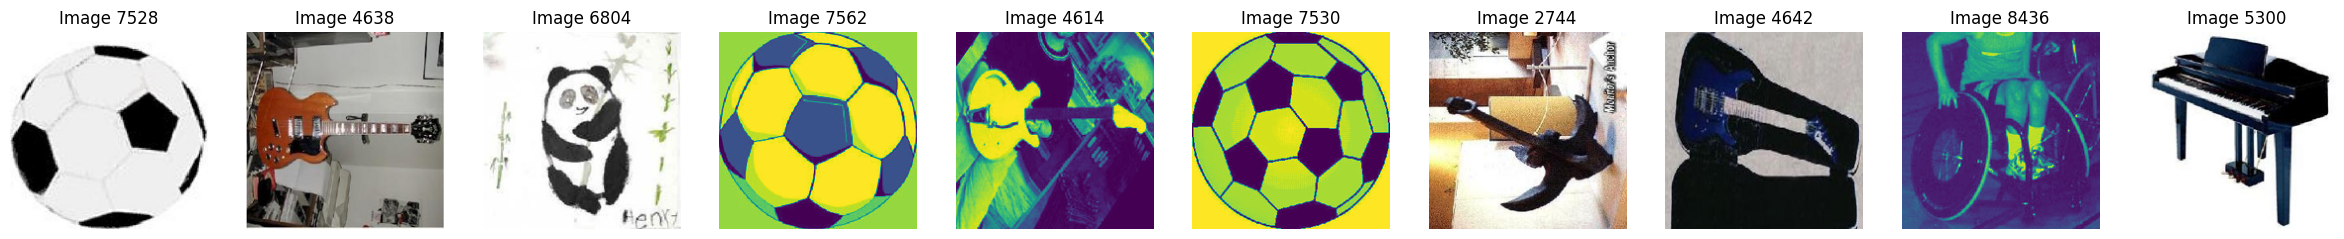

In [34]:
query_image_index = int(input("Enter the query image id: "))

t = int(input("Enter the number of most likely images to retrive, t: "))

lsh = load_lsh_index_from_file(f'{path}/LSH_index_structures/lsh_index_structure_10_10.pkl')
odd_indices = [i for i in range(1, len(caltech_dataset), 2)]
# for each in odd_indices:
#   similar_images, unique_images, total_images = similar_image_search_lsh(lsh, each, t)
#   print("unique: ", unique_images)
similar_images, unique_images, total_images = similar_image_search_lsh(lsh, query_image_index, t)

print("Original Image")
display(caltech_dataset[int(query_image_index)][0].resize((150,150)))

print(f"\nNumber of Unique Images Considered: {unique_images}")
print(f"Total Number of Images: {total_images}")

display_images(similar_images,caltech_dataset, 200, 200)